<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill for Air Quality Data</span>


## 🗒️ You have the following tasks
1. Choose an Air Quality Sensor
2. Update the country, city, and street information to point to YOUR chosen Air Quality Sensor
3. Download historical measures for your Air Quality Sensor as a CSV file
4. Update the path of the CSV file in this notebook to point to the one that you downloaded
5. Create an account on www.hopsworks.ai and get your HOPSWORKS_API_KEY
6. Run this notebook



### <span style='color:#ff5f27'> 📝 Imports

In [61]:
import datetime
import requests
import pandas as pd
import hopsworks
import datetime
from pathlib import Path
from functions import util
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")

### IF YOU WANT TO WIPE OUT ALL OF YOUR FEATURES AND MODELS, run the cell below

In [62]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""
# proj = hopsworks.login()
# util.purge_project(proj)

## <span style='color:#ff5f27'> 🌍 STEP 1: Pick your Air Quality Sensor</span>

Vienna, Austria

* Historical air quality data: aqicn.org/historical/#city:austria/ecke-taborstrasse-glockengasse
* Real-time air quality data: aqicn.org/station/austria/ecke-taborstrasse-glockengasse

With your URL, we will need to do two things:

 * download the historical air quality readings as a CSV file
 * note down the URL for the real-time API (you will need to create an API key for accessing this).

If your sensor's URL has one of the first two formats (the first URL path component is `station`), you will find the links to both historical CSV data and the real-time API on the same web page.

However, if your sensor's URL has the last format above (the first URL path component is `city` instead of `station`), then you will need to use 2 different URLs - one to download the historical CSV data and one for the real-time air quality measurements. You will find both of those links in the "Air quality historical data" section. Click on the "Historical air quality data" when you need to download the CSV file, and when you need the real-time API, click on the "Real-time air quality data".


__Write down the country, city, and the street for your sensor.__

We will use the city name to download weather data for your sensor, and we will store the country and street values in the sensor's feature group.

---

## <span style='color:#ff5f27'> 🌍 STEP 2: Download the Historical Air Quality </span>

You can download a CSV file containing the historical air quality data from your your sensor's URL.
Scroll down to the section "Air Quality Historical Data". Click on the PM2.5 option and save the file to the `data` directory in your forked version of this Github repository. Note the name of your CSV file, you will need 

## <span style='color:#ff5f27'> 🌍 STEP 3: Get the AQICN_URL and API key. Enter country, city, street names for your Sensor.</span>

You can find your __AQICN_URL__ if you scroll down the webpage for your sensor.
You shouldn't include the last part of the url - "/?token=\__YOUR_TOKEN\__". 
It is bad practice to save TOKENs (aka API KEYs) in your source code - you might make it public if you check that code into Github!
We will fill in the token later by saving the AQI_API_KEY as a secret in Hopsworks.


__Update the values in the cell below.__

In [63]:
csv_file="../data/vienna-taborstraße-glockengasse-air-quality.csv"
util.check_file_path(csv_file)

File successfully found at the path: ../data/vienna-taborstraße-glockengasse-air-quality.csv


In [64]:
country="austria"
city = "vienna"
street = "vienna-taborstraße-glockengasse"
aqicn_url="https://api.waqi.info/feed/@2860"

# This API call may fail if the IP address you run this notebook from is blocked by the Nominatim API
# If this fails, lookup the latitude, longitude using Google and enter the values here.
latitude, longitude = util.get_city_coordinates(city)

today = datetime.date.today()

## <span style='color:#ff5f27'> 🌍 STEP 4: Get an AQI API Token and Store it as a Secret in Hopsworks </span>

You have to first get your AQI API key [from here](https://aqicn.org/data-platform/token/):

Save the API KEY to a new file you need to create in your repository (do not check this file into Github!):

 * <project root>/data/aqi-api-key.txt

In [65]:
aqi_api_key_file = '../data/aqi-api-key.txt'
util.check_file_path(aqi_api_key_file)

with open(aqi_api_key_file, 'r') as file:
    AQI_API_KEY = file.read().rstrip()

File successfully found at the path: ../data/aqi-api-key.txt


## Hopsworks API Key
You need to have registered an account on app.hopsworks.ai.
You will be prompted to enter your API key here, unless you set it as the environment variable HOPSWORKS_API_KEY (my preffered approach).

In [66]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

# project = hopsworks.connection().get_project("ID2223_Hosl_Ghosh")  # or use "id2223_scalable_lab1" based on your choice    
project = hopsworks.login()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159326


In [67]:
secrets = util.secrets_api(project.name)
try:
    secrets.create_secret("AQI_API_KEY", AQI_API_KEY)
except hopsworks.RestAPIError:
    AQI_API_KEY = secrets.get_secret("AQI_API_KEY").value

Connected. Call `.close()` to terminate connection gracefully.


### Validate that the AQI_API_KEY you added earlier works

The cell below should print out something like:

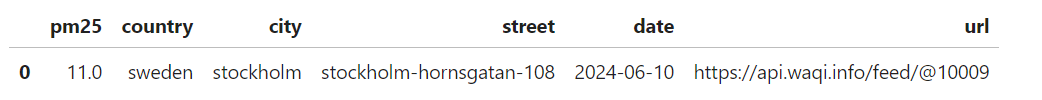

In [68]:
try:
    aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQI_API_KEY)
except hopsworks.RestAPIError:
    print("It looks like the AQI_API_KEY doesn't work for your sensor. Is the API key correct? Is the sensor URL correct?")

aq_today_df.head()

pm25  country    city                           street       date  \
0  13.0  austria  vienna  vienna-taborstraße-glockengasse 2024-11-18   

                                url  
0  https://api.waqi.info/feed/@2860

## <span style='color:#ff5f27'> 🌍 STEP 5: Read your CSV file into a DataFrame </span>

The cell below will read up historical air quality data as a CSV file into a Pandas DataFrame

In [69]:
df = pd.read_csv(csv_file,  parse_dates=['date'], skipinitialspace=True)
df

date  pm25  pm10   no2  co
0    2024-11-01  63.0  13.0   5.0 NaN
1    2024-11-02  42.0  15.0  15.0 NaN
2    2024-11-03  48.0  19.0  16.0 NaN
3    2024-11-04  54.0  20.0  15.0 NaN
4    2024-11-05  61.0   NaN   NaN NaN
...         ...   ...   ...   ...  ..
3945 2014-12-31   NaN  33.0  15.0 NaN
3946 2014-10-29   NaN  62.0  27.0 NaN
3947 2014-05-11   NaN   6.0   9.0 NaN
3948 2013-12-31   NaN  42.0  11.0 NaN
3949 2024-04-10   NaN   NaN  10.0 NaN

[3950 rows x 5 columns]

## <span style='color:#ff5f27'> 🌍 STEP 6: Data cleaning</span>


### Rename columns if needed and drop unneccessary columns

We want to have a DataFrame with 2 columns - `date` and `pm25` after this cell below:

## Check the data types for the columns in your DataFrame

 * `date` should be of type   datetime64[ns] 
 * `pm25` should be of type float64

In [70]:
# These commands will succeed if your CSV file didn't have a `median` or `timestamp` column
df = df.rename(columns={"median": "pm25"})
df = df.rename(columns={"timestamp": "date"})

df_aq = df[['date', 'pm25']].copy()
df_aq['pm25'] = df_aq['pm25'].astype('float32')

'''
# Copy df_aq to df_aq_lag
df_aq_lag = df_aq.copy()
df_aq_lag.set_index('date', inplace=True)
df_aq_lag['pm25_prev'] = df_aq_lag['pm25'].rolling(window=3).mean()
df_aq_lag.reset_index(inplace=True)

df_aq_lag
'''

"\n# Copy df_aq to df_aq_lag\ndf_aq_lag = df_aq.copy()\ndf_aq_lag.set_index('date', inplace=True)\ndf_aq_lag['pm25_prev'] = df_aq_lag['pm25'].rolling(window=3).mean()\ndf_aq_lag.reset_index(inplace=True)\n\ndf_aq_lag\n"

In [71]:
# Show info
df_aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3950 non-null   datetime64[ns]
 1   pm25    3924 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 46.4 KB


## <span style='color:#ff5f27'> 🌍 STEP 7: Drop any rows with missing data </span>
It will make the model training easier if there is no missing data in the rows, so we drop any rows with missing data.

In [72]:
df_aq.dropna(inplace=True)

## <span style='color:#ff5f27'> 🌍 STEP 8: Add country, city, street, url to the DataFrame </span>

Your CSV file may have many other air quality measurement columns. We will only work with the `pm25` column.

We add the columns for the country, city, and street names that you changed for your Air Quality sensor.

We also want to make sure the `pm25` column is a float32 data type.

In [73]:
# Your sensor may have columns we won't use, so only keep the date and pm25 columns
# If the column names in your DataFrame are different, rename your columns to `date` and `pm25`
df_aq['country']=country
df_aq['city']=city
df_aq['street']=street
df_aq['url']=aqicn_url

---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## <span style='color:#ff5f27'> 🌍 STEP 9: Download the Historical Weather Data </span>

https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

We will download the historical weather data for your `city` by first extracting the earliest date from your DataFrame containing the historical air quality measurements.

We will download all daily historical weather data measurements for your `city` from the earliest date in your air quality measurement DataFrame. It doesn't matter if there are missing days of air quality measurements. We can store all of the daily weather measurements, and when we build our training dataset, we will join up the air quality measurements for a given day to its weather features for that day. 

The weather features we will download are:

 * `temperature (average over the day)`
 * `precipitation (the total over the day)`
 * `wind speed (average over the day)`
 * `wind direction (the most dominant direction over the day)`


In [74]:
earliest_aq_date = pd.Series.min(df_aq['date'])
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

weather_df = util.get_historical_weather(city, earliest_aq_date, str(today), latitude, longitude)

Coordinates 48.18980407714844°N 16.377296447753906°E
Elevation 194.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [75]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3973 entries, 0 to 3972
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3973 non-null   datetime64[ns]
 1   temperature_2m_mean          3973 non-null   float32       
 2   precipitation_sum            3973 non-null   float32       
 3   wind_speed_10m_max           3973 non-null   float32       
 4   wind_direction_10m_dominant  3973 non-null   float32       
 5   city                         3973 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 155.2+ KB


## <span style='color:#ff5f27'> 🌍 STEP 10: Define Data Validation Rules </span>

We will validate the air quality measurements (`pm25` values) before we write them to Hopsworks.

We define a data validation rule (an expectation in Great Expectations) that ensures that `pm25` values are not negative or above the max value available by the sensor.

We will attach this expectation to the air quality feature group, so that we validate the `pm25` data every time we write a DataFrame to the feature group. We want to prevent garbage-in, garbage-out.

In [76]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":500.0,
            "strict_min":True
        }
    )
)

{"expectation_type": "expect_column_min_to_be_between", "kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 500.0, "strict_min": true}, "meta": {}}

## Expectations for Weather Data
Here, we define an expectation for 2 columns in our weather DataFrame - `precipitation_sum` and `wind_speed_10m_max`, where we expect both values to be greater than zero, but less than 1000.

In [77]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

### <span style="color:#ff5f27;"> 🔮 STEP 11: Connect to Hopsworks and save the sensor country, city, street names as a secret</span>

In [78]:
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.


#### Save country, city, street names as a secret

These will be downloaded from Hopsworks later in the (1) daily feature pipeline and (2) the daily batch inference pipeline

In [79]:
dict_obj = {
    "country": country,
    "city": city,
    "street": street,
    "aqicn_url": aqicn_url,
    "latitude": latitude,
    "longitude": longitude
}

# Convert the dictionary to a JSON string
str_dict = json.dumps(dict_obj)

try:
    secrets.create_secret("SENSOR_LOCATION_JSON", str_dict)
except hopsworks.RestAPIError:
    print("SENSOR_LOCATION_JSON already exists. To update, delete the secret in the UI (https://c.app.hopsworks.ai/account/secrets) and re-run this cell.")
    existing_key = secrets.get_secret("SENSOR_LOCATION_JSON").value
    print(f"{existing_key}")

SENSOR_LOCATION_JSON already exists. To update, delete the secret in the UI (https://c.app.hopsworks.ai/account/secrets) and re-run this cell.
{"country": "austria", "city": "vienna", "street": "vienna-taborstra\u00dfe-glockengasse", "aqicn_url": "https://api.waqi.info/feed/@2860", "latitude": 48.21, "longitude": 16.37}


### <span style="color:#ff5f27;"> 🔮 STEP 12: Create the Feature Groups and insert the DataFrames in them </span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each air quality sensor measurement is uniquely identified by `country`, `street`, and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [80]:
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['city', 'street', 'date'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)

air_quality_lag_fg = fs.get_or_create_feature_group(
    name="air_quality_with_rolling_window_3_days",
    version=1,
    primary_key=air_quality_fg.primary_key,  # Same primary key as the existing group
    event_time="date",
    description="Air Quality characteristics of each day including the mean 25pm of the previous three days"
)

#### Insert the DataFrame into the Feature Group

In [81]:
air_quality_fg.insert(df_aq)

2024-11-18 22:41:10,269 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1159326/fs/1150029/fg/1338743


Uploading Dataframe: 0.00% |          | Rows 0/3924 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159326/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x26cbc0f1520>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "pm25",
           "min_value": -0.1,
           "max_value": 500.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 662538
         }
       },
       "result": {
         "observed_value": 5.0,
         "element_count": 3924,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-11-18T09:41:10.000269Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     }
   ],
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 1,
     "successful_expectations": 1,
     "un

In [82]:
df = air_quality_fg.read()
df.set_index('date', inplace=True)
df['pm25_prev'] = df['pm25'].rolling(window=3).mean()
df.reset_index(inplace=True)
df.dropna(inplace=True)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 


In [83]:
air_quality_lag_fg.insert(df)

Uploading Dataframe: 0.00% |          | Rows 0/3935 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_with_rolling_window_3_days_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159326/jobs/named/air_quality_with_rolling_window_3_days_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x26cbe4e97f0>, None)

#### Enter a description for each feature in the Feature Group

In [84]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")

air_quality_lag_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_lag_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_lag_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_lag_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_lag_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")
air_quality_lag_fg.update_feature_description("pm25_prev", "mean pm25 value of last three days")

### <span style='color:#ff5f27'> 🌦 Weather Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each weather measurement is uniquely identified by `city` and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [85]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city', 'date'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

#### Insert the DataFrame into the Feature Group

In [86]:
# Insert data
weather_fg.insert(weather_df)

2024-11-18 22:41:37,438 INFO: 	2 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1159326/fs/1150029/fg/1337716


Uploading Dataframe: 0.00% |          | Rows 0/3973 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159326/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x26c953fb610>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "precipitation_sum",
           "min_value": -0.1,
           "max_value": 1000.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 661515
         }
       },
       "result": {
         "observed_value": 0.0,
         "element_count": 3973,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-11-18T09:41:37.000438Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     },
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_bet

#### Enter a description for each feature in the Feature Group

In [87]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Daily Feature Pipeline 
 </span> 


## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 

Extra Homework:

  * Try adding a new feature based on a rolling window of 3 days for 'pm25'
      * This is not easy, as forecasting more than 1 day in the future, you won't have the previous 3 days of pm25 measurements.
      * df.set_index("date").rolling(3).mean() is only the start....
  * Parameterize the notebook, so that you can provide the `country`/`street`/`city`/`url`/`csv_file` as parameters. 
      * Hint: this will also require making the secret name (`SENSOR_LOCATION_JSON`), e.g., add the street name as part of the secret name. Then you have to pass that secret name as a parameter when running the operational feature pipeline and batch inference pipelines.
      * After you have done this, collect the street/city/url/csv files for all the sensors in your city or region and you make dashboards for all of the air quality sensors in your city/region. You could even then add a dashboard for your city/region, as done [here for Poland](https://github.com/erno98/ID2223).

Improve this AI System
  * As of mid 2024, there is no API call available to download historical data from the AQIN website. You could improve this system by writing a PR to download the CSV file using Python Selenium and the URL for the sensor.


---